In [1]:
from mlwpy import *
from helpers import *

iris = datasets.load_iris()
(iris_train,     iris_test, 
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                        iris.target, 
                                                        test_size=.25)
# remove units ' (cm)' from names
iris.feature_names = [fn[:-5] for fn in iris.feature_names]

# dataframe for convenience
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

# Feature Scaling

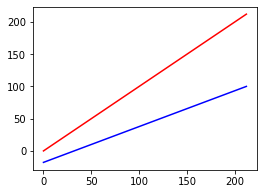

In [2]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
f_temps = np.linspace(0, 212, 100)
c_temps = (5/9) * (f_temps - 32)
plt.plot(f_temps, f_temps, 'r',   # F -> F
         f_temps, c_temps, 'b');  # F -> C

In [3]:
# orig ---->     (orig - mean) / standard deviation 
#      ---->   (1 / sd) (orig - mean)

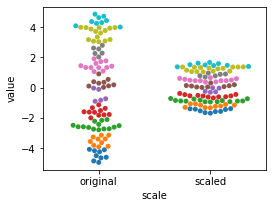

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
original = np.random.uniform(-5, 5, 100)

scaled = (skpre.StandardScaler()
               .fit_transform(original.reshape(-1,1))[:,0])
bins = np.floor(original).astype(np.uint8) + 5

df = pd.DataFrame({'original':original,
                   'scaled':scaled,
                   'hue':bins})
df = pd.melt(df, id_vars='hue', var_name='scale')

sns.swarmplot(x='scale', y='value', hue='hue', data=df).legend_.remove()

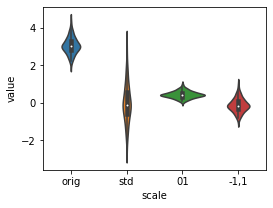

In [5]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

df = pd.DataFrame({'orig':iris_df['sepal width']})

scalers = [('std', skpre.StandardScaler()),
           ('01' , skpre.MinMaxScaler()),
           ('-1,1', skpre.MinMaxScaler((-1,1)))]

for name, scaler in scalers:
     # ugly:  [[]] to keep 2D for sklearn
     #        reshape(-1) to go back to 1-D for seaborn  :(
    df[name] = scaler.fit_transform(df[['orig']]).reshape(-1)

df = pd.melt(df, var_name='scale')
sns.violinplot(x='scale', y='value', data=df);

# Discretization

In [6]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
display(iris_df.iloc[[0,50,100]])

,sepal length,sepal width,petal length,petal width,species
0,5.1000,3.5000,1.4000,0.2000,setosa
50,7.0000,3.2000,4.7000,1.4000,versicolor
100,6.3000,3.3000,6.0000,2.5000,virginica


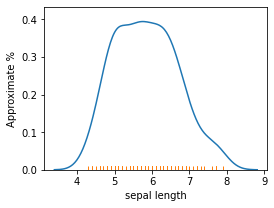

In [7]:
plt.subplots(1,1,figsize=(4,3))
ax = sns.kdeplot(data=iris_df, x="sepal length")
sns.rugplot(data=iris_df, x="sepal length")
ax.set_ylabel("Approximate %");

In [8]:
# apply binary threshold to numeric with sklearn is tricky
column = iris_df[['sepal length']] # keep 2Dness b/c sk complains
col_mean = column.mean().values    # and sk fails with Series/DF

both = column.copy()
both['> Mean'] = skpre.binarize(column, threshold=col_mean).astype(bool)

print('Column Mean:', col_mean)
display(both.iloc[[0,50,100]])

Column Mean: [5.8433]


,sepal length,> Mean
0,5.1000,False
50,7.0000,True
100,6.3000,True


In [9]:
# an easy button:
np.where(column > column.mean(), True, False)[[0,50,100]]

array([[False],
       [ True],
       [ True]])

In [10]:
# uglier ....
sep_len_series = iris_df['sepal length']
breaks = [sep_len_series.mean(), 
          sep_len_series.max()]

print(pd.cut(sep_len_series, breaks).cat.codes[[0, 50, 100]])

0     -1
50     0
100    0
dtype: int8


In [11]:
# but we can extend it
sep_len_series = iris_df['sepal length']
breaks = np.percentile(sep_len_series, [25, 50, 75, 100])
print(pd.cut(sep_len_series, breaks).cat.codes[[0, 50, 100]])

0     -1
50     2
100    1
dtype: int8


# Categorical Coding

In [12]:

new_iris_df = pd.DataFrame(iris_df, columns=['petal length', 
                                             'petal width', 
                                             'species'])

new_iris_df.columns = pd.MultiIndex([['input ftrs', 'target ftr'],
                                      new_iris_df.columns], 
                                     [[1, 0, 0], [0,1,2]])

new_iris_df.sort_index(axis='columns', inplace=True)
display(new_iris_df.iloc[[0,50,100]])

input ftrs                       target ftr
             petal width     species         petal length
0                 0.2000      setosa               1.4000
50                1.4000  versicolor               4.7000
100               2.5000   virginica               6.0000

In [13]:
# start with category numbers
print("Numerical categories:",
      iris.target[[0, 50, 100]], sep='\n')

# produces sparse representation
sparse = (skpre.OneHotEncoder(categories='auto')
               .fit_transform(iris.target.reshape(-1,1)))

# densify it
print("One-hot coding:", 
      sparse[[0,50,100]].todense(), sep="\n")

Numerical categories:
[0 1 2]
One-hot coding:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [14]:
encoded = pd.get_dummies(iris_df, prefix="is") 
encoded.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,is_setosa,is_versicolor,is_virginica
0,5.1000,3.5000,1.4000,0.2000,1,0,0
50,7.0000,3.2000,4.7000,1.4000,0,1,0
100,6.3000,3.3000,6.0000,2.5000,0,0,1


In [15]:
# can use drop_first to avoid "difficulties"
encoded = pd.get_dummies(iris_df, prefix="is", drop_first=True) 
encoded.iloc[[0,50,100]]

,sepal length,sepal width,petal length,petal width,is_versicolor,is_virginica
0,5.1000,3.5000,1.4000,0.2000,0,0
50,7.0000,3.2000,4.7000,1.4000,1,0
100,6.3000,3.3000,6.0000,2.5000,0,1


# Interactions

##### Manual Feature Construction

In [16]:
xor_df = make_xor()
display(xor_df)

,x1,x2,tgt
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


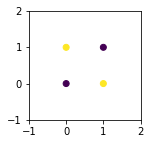

In [17]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.scatter('x1', 'x2', data=xor_df, c='tgt')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2);

LogisticRegression()

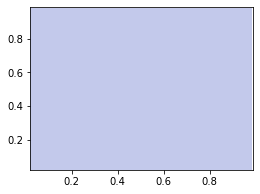

In [18]:
plot_boundary(xor_df[['x1', 'x2']], xor_df['tgt'], [0,1], 
              linear_model.LogisticRegression())

In [19]:
xor_df['new'] = (-1)**xor_df['x1'] * (-1)**xor_df['x2']
xor_df[['x1', 'x2', 'new']]

,x1,x2,new
0,0,0,1
1,0,1,-1
2,1,0,-1
3,1,1,1


In [20]:
model = linear_model.LogisticRegression().fit(xor_df[['new']], 
                                              xor_df['tgt'])
model.predict(xor_df[['new']])

array([0, 1, 1, 0])

##### Interaction Terms

In [21]:
# degree -- highest power of x to consider
# inter_only -- no x_1**2, would have x_1 * x_2
# inc_bias -- whether to include a constant term
quad_inters = skpre.PolynomialFeatures(degree=2,
                                       interaction_only=True,
                                       include_bias=False)
subset = iris_df.loc[[0, 50, 100], ['sepal length', 'sepal width']]
new_terms = pd.DataFrame(quad_inters.fit_transform(subset), 
                         index=[0, 50, 100])
new_terms.set_axis(['sep length', 'sep width', 'sep area'], 
                   axis=1, inplace=True)
display(new_terms)

,sep length,sep width,sep area
0,5.1000,3.5000,17.8500
50,7.0000,3.2000,22.4000
100,6.3000,3.3000,20.7900


In [22]:
sepal_area = iris_df['sepal length'] * iris_df['sepal width']
petal_area = iris_df['petal length'] * iris_df['petal width']

In [23]:
# ... and discretize 
iris_df['big_sepal'] = sepal_area > sepal_area.median()
iris_df['big_petal'] = petal_area > petal_area.median()
display(iris_df.iloc[[0,50,100]])

,sepal length,sepal width,petal length,petal width,species,big_sepal,big_petal
0,5.1000,3.5000,1.4000,0.2000,setosa,True,False
50,7.0000,3.2000,4.7000,1.4000,versicolor,True,True
100,6.3000,3.3000,6.0000,2.5000,virginica,True,True


##### Custom Transformers

In [24]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

area_df = pd.DataFrame({"sepal_area" : iris_df['sepal length'] * 
                                       iris_df['sepal width'],
                        "petal_area" : iris_df['petal length'] * 
                                       iris_df['petal width']})

In [25]:
def median_big_small(d):
    return d > np.median(d)

transformer = skpre.FunctionTransformer(median_big_small)
res = transformer.fit_transform(area_df)

In [26]:
print("Large areas as compared to median?")
print(res.iloc[[0, 50, 100]])

Large areas as compared to median?
     sepal_area  petal_area
0          True       False
50         True       False
100        True        True


In [27]:
from sklearn.base import TransformerMixin

class Median_Big_Small(TransformerMixin):
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

In [28]:
# training-testing split
training, testing = skms.train_test_split(area_df)
    
# create and run the transformer
transformer = Median_Big_Small()
train_xform = transformer.fit_transform(training)
test_xform  = transformer.transform(testing)

# the dataframes survived!
print('train:')
display(train_xform[:3])
print('test:')
display(test_xform[ :3])

train:


,sepal_area,petal_area
39,True,False
141,True,False
64,True,False


test:


,sepal_area,petal_area
128,True,False
78,True,False
113,True,False
